Reference:

https://github.com/tensorflow/probability/blob/v0.7/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import numpy as np

print("TensorFlow", tf.__version__)
print("TensorFlow Probability", tfp.__version__)
print("TensorFlow Datasets", tfds.version.__version__)
print("GPU Available:", tf.test.gpu_device_name())

TensorFlow 2.0.0-beta1
TensorFlow Probability 0.7.0
TensorFlow Datasets 1.0.2
GPU Available: /device:GPU:0


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import SVG

def display_images(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
        fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
        axs.flat[i].imshow(x[i].squeeze(), interpolation="none", cmap="gray")
        axs.flat[i].axis("off")
    plt.show()
    plt.close()
    plt.ion()

def display_model(model, **kvargs):
    dot = tf.keras.utils.model_to_dot(model, show_shapes=True, dpi=72, **kvargs)
    svg = dot.create(prog="dot", format="svg")
    display(SVG(svg))

## Classifier

In [3]:
tf.keras.backend.clear_session()

In [4]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=True)

print(datasets_info.features)

FeaturesDict({'image': Image(shape=(28, 28, 1), dtype=tf.uint8), 'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)})


In [5]:
def _preprocess(images, labels):
    images = tf.cast(images, tf.float32) / 255.  # Scale to unit interval.
    return images, labels

train_dataset = datasets["train"] \
                    .prefetch(tf.data.experimental.AUTOTUNE) \
                    .map(_preprocess) \
                    .shuffle(1024) \
                    .batch(64)

eval_dataset = datasets["test"] \
                    .prefetch(tf.data.experimental.AUTOTUNE) \
                    .map(_preprocess) \
                    .batch(64)

print("Train:", train_dataset)
print("Eval :", eval_dataset)

Train: <BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>
Eval : <BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


In [6]:
input_shape = datasets_info.features["image"].shape
num_classes = datasets_info.features["label"].num_classes
hidden_size = 32

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


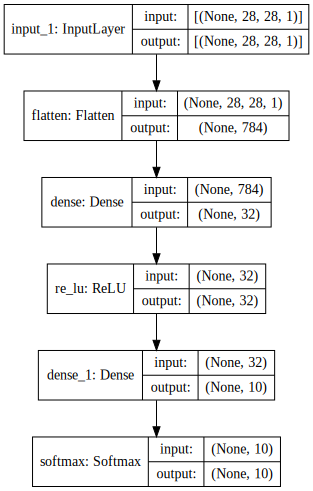

In [7]:
classifier = tf.keras.models.Sequential(
    name="classifier",
    layers=[
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=hidden_size),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(units=num_classes),
        tf.keras.layers.Softmax(),
    ])

classifier.summary()

display_model(classifier)

In [8]:
classifier.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.metrics.SparseCategoricalAccuracy()])

In [9]:
classifier.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=5,
    verbose=2)

Epoch 1/5


W0705 01:05:42.826603 139970521351936 deprecation.py:323] From /home/user/software/conda/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


938/938 - 18s - loss: 0.4152 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/5
938/938 - 15s - loss: 0.2135 - sparse_categorical_accuracy: 0.9397 - val_loss: 0.1884 - val_sparse_categorical_accuracy: 0.9478
Epoch 3/5
938/938 - 15s - loss: 0.1693 - sparse_categorical_accuracy: 0.9527 - val_loss: 0.1717 - val_sparse_categorical_accuracy: 0.9504
Epoch 4/5
938/938 - 15s - loss: 0.1435 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.1495 - val_sparse_categorical_accuracy: 0.9593
Epoch 5/5
938/938 - 15s - loss: 0.1254 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.1346 - val_sparse_categorical_accuracy: 0.9626


In [10]:
classifier.evaluate(eval_dataset, verbose=2)

[0.1345932212462471, 0.9626]

## Autoencoder

In [11]:
tf.keras.backend.clear_session()

In [12]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

print(datasets_info.features)

FeaturesDict({'image': Image(shape=(28, 28, 1), dtype=tf.uint8), 'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)})


In [13]:
def _preprocess(sample):
    image = tf.cast(sample["image"], tf.float32) / 255.  # Scale to unit interval.
    image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
    return image, image

train_dataset = datasets["train"] \
                    .prefetch(tf.data.experimental.AUTOTUNE) \
                    .map(_preprocess) \
                    .shuffle(1024) \
                    .batch(64)

eval_dataset = datasets["test"] \
                    .prefetch(tf.data.experimental.AUTOTUNE) \
                    .map(_preprocess) \
                    .batch(64)

print("Train:", train_dataset)
print("Eval :", eval_dataset)

Train: <BatchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.bool, tf.bool)>
Eval : <BatchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.bool, tf.bool)>


In [14]:
input_shape = datasets_info.features['image'].shape
output_size = np.prod(input_shape)
encoded_size = 8
hidden_size = 32

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                1452      
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 8), (None, 8))    0         
Total params: 26,572
Trainable params: 26,572
Non-trainable params: 0
_______________________________________________________

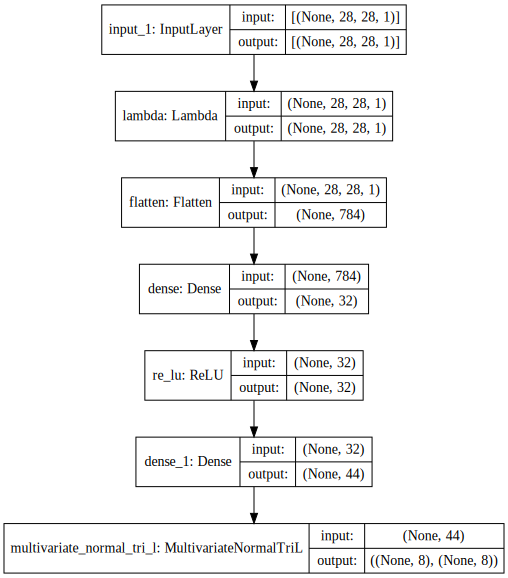

In [15]:
prior = tfp.distributions.Normal(loc=tf.zeros(encoded_size), scale=1) # loc = mean, scale = std
prior = tfp.distributions.Independent(prior, reinterpreted_batch_ndims=1)

encoder = tf.keras.models.Sequential(
    name="encoder",
    layers=[
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=hidden_size),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(
            units=tfp.layers.MultivariateNormalTriL.params_size(encoded_size),
            activation=None),
        tfp.layers.MultivariateNormalTriL(
            encoded_size,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior)),
    ])

encoder.summary()

display_model(encoder)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                288       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               25872     
_________________________________________________________________
independent_bernoulli (Indep ((None, 28, 28, 1), (None 0         
Total params: 26,160
Trainable params: 26,160
Non-trainable params: 0
_________________________________________________________________


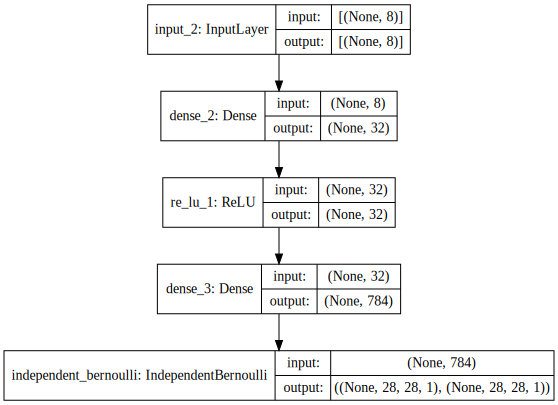

In [16]:
decoder = tf.keras.models.Sequential(
    name="decoder",
    layers=[
        tf.keras.layers.InputLayer(input_shape=[encoded_size]),
        tf.keras.layers.Dense(units=hidden_size),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(units=output_size),
        tfp.layers.IndependentBernoulli(input_shape, tfp.distributions.Bernoulli.logits),
    ])

decoder.summary()

display_model(decoder)

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                1452      
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 8), (None, 8))    0       

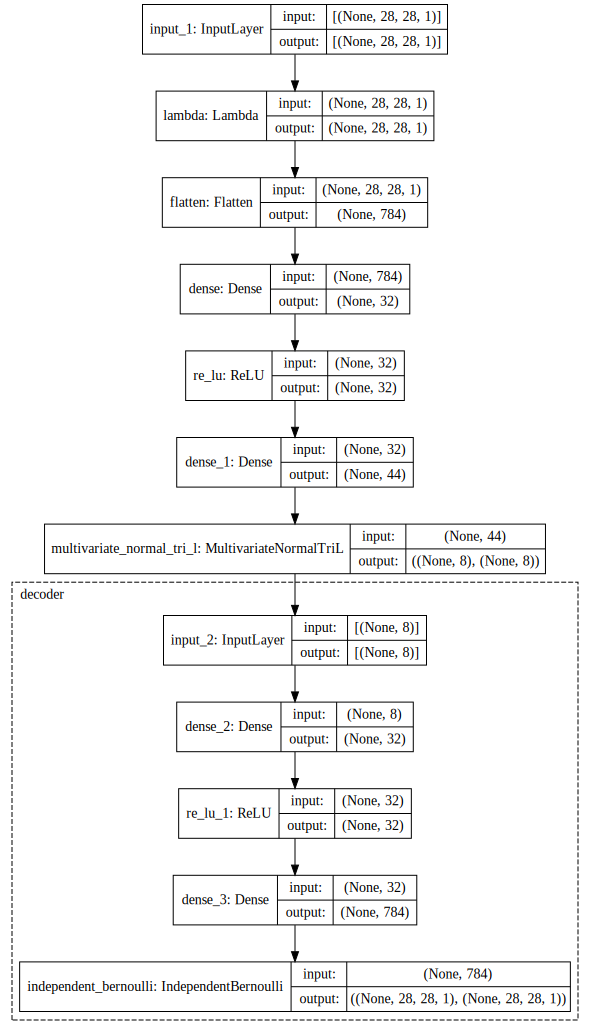

In [17]:
vae = tf.keras.models.Model(
    name="VAE",
    inputs=encoder.inputs,
    outputs=decoder(encoder.outputs[0]))

vae.summary()
decoder.summary()

display_model(vae, expand_nested=True)

In [18]:
negative_log_likelihood = lambda x, y: -y.log_prob(x) # y is a Random Variable

vae.compile(
    optimizer=tf.optimizers.Adam(),
    loss=negative_log_likelihood,
    metrics=[tf.metrics.BinaryAccuracy()])

vae.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=10,
    verbose=2)

Epoch 1/10
938/938 - 20s - loss: 221.3242 - binary_accuracy: 0.8409 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/10
938/938 - 18s - loss: 187.2685 - binary_accuracy: 0.8768 - val_loss: 177.0571 - val_binary_accuracy: 0.8879
Epoch 3/10
938/938 - 19s - loss: 171.2331 - binary_accuracy: 0.8924 - val_loss: 166.6253 - val_binary_accuracy: 0.8963
Epoch 4/10
938/938 - 18s - loss: 165.2223 - binary_accuracy: 0.8969 - val_loss: 163.7982 - val_binary_accuracy: 0.9003
Epoch 5/10
938/938 - 18s - loss: 162.1487 - binary_accuracy: 0.8998 - val_loss: 160.5073 - val_binary_accuracy: 0.9035
Epoch 6/10
938/938 - 18s - loss: 159.8643 - binary_accuracy: 0.9022 - val_loss: 158.4149 - val_binary_accuracy: 0.9043
Epoch 7/10
938/938 - 18s - loss: 158.5928 - binary_accuracy: 0.9034 - val_loss: 158.3552 - val_binary_accuracy: 0.9042
Epoch 8/10
938/938 - 18s - loss: 157.8159 - binary_accuracy: 0.9041 - val_loss: 156.8234 - val_binary_accuracy: 0.9056
Epoch 9/10
938/938 - 18s - loss: 157.2354 

Originals:


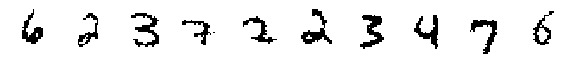

Decoded Random Samples:


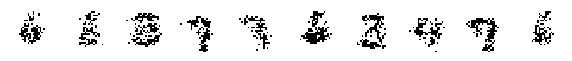

Decoded Modes:


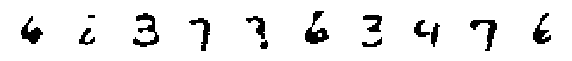

Decoded Means:


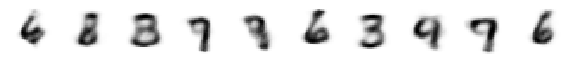

In [19]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfp.distributions.Distribution)

print("Originals:")
display_images(x)

print("Decoded Random Samples:")
display_images(xhat.sample())

print("Decoded Modes:")
display_images(xhat.mode())

print("Decoded Means:")
display_images(xhat.mean())

Randomly Generated Samples:


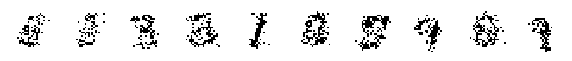

Randomly Generated Modes:


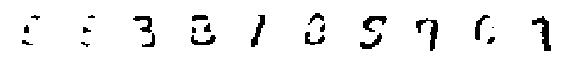

Randomly Generated Means:


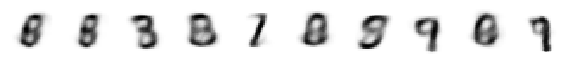

In [20]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfp.distributions.Distribution)

print("Randomly Generated Samples:")
display_images(xtilde.sample())

print("Randomly Generated Modes:")
display_images(xtilde.mode())

print("Randomly Generated Means:")
display_images(xtilde.mean())

## Semi-supervised Learning

In [21]:
tf.keras.backend.clear_session()

In [22]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=True)

print(datasets_info.features)

FeaturesDict({'image': Image(shape=(28, 28, 1), dtype=tf.uint8), 'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)})


In [23]:
def _preprocess(images, labels):
    images = tf.cast(images, tf.float32) / 255.             # Scale to unit interval.
    images = images < tf.random.uniform(tf.shape(images))   # Randomly binarize.
    return {"encoder_input": images}, {"decoder": images, "classifier": labels}

train_dataset = datasets["train"] \
                    .prefetch(tf.data.experimental.AUTOTUNE) \
                    .map(_preprocess) \
                    .shuffle(1024) \
                    .batch(64)

eval_dataset = datasets["test"] \
                    .prefetch(tf.data.experimental.AUTOTUNE) \
                    .map(_preprocess) \
                    .batch(64)

print("Train:", train_dataset)
print("Eval :", eval_dataset)

Train: <BatchDataset shapes: ({encoder_input: (None, 28, 28, 1)}, {decoder: (None, 28, 28, 1), classifier: (None,)}), types: ({encoder_input: tf.bool}, {decoder: tf.bool, classifier: tf.int64})>
Eval : <BatchDataset shapes: ({encoder_input: (None, 28, 28, 1)}, {decoder: (None, 28, 28, 1), classifier: (None,)}), types: ({encoder_input: tf.bool}, {decoder: tf.bool, classifier: tf.int64})>


In [24]:
input_shape = datasets_info.features['image'].shape
num_classes = datasets_info.features["label"].num_classes
output_size = np.prod(input_shape)
encoded_size = 16
hidden_size = 64

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 28, 28, 1)    0           encoder_input[0][0]              
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           lambda[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           50240       flatten[0][0]                    
________________________________________________________________________________________________

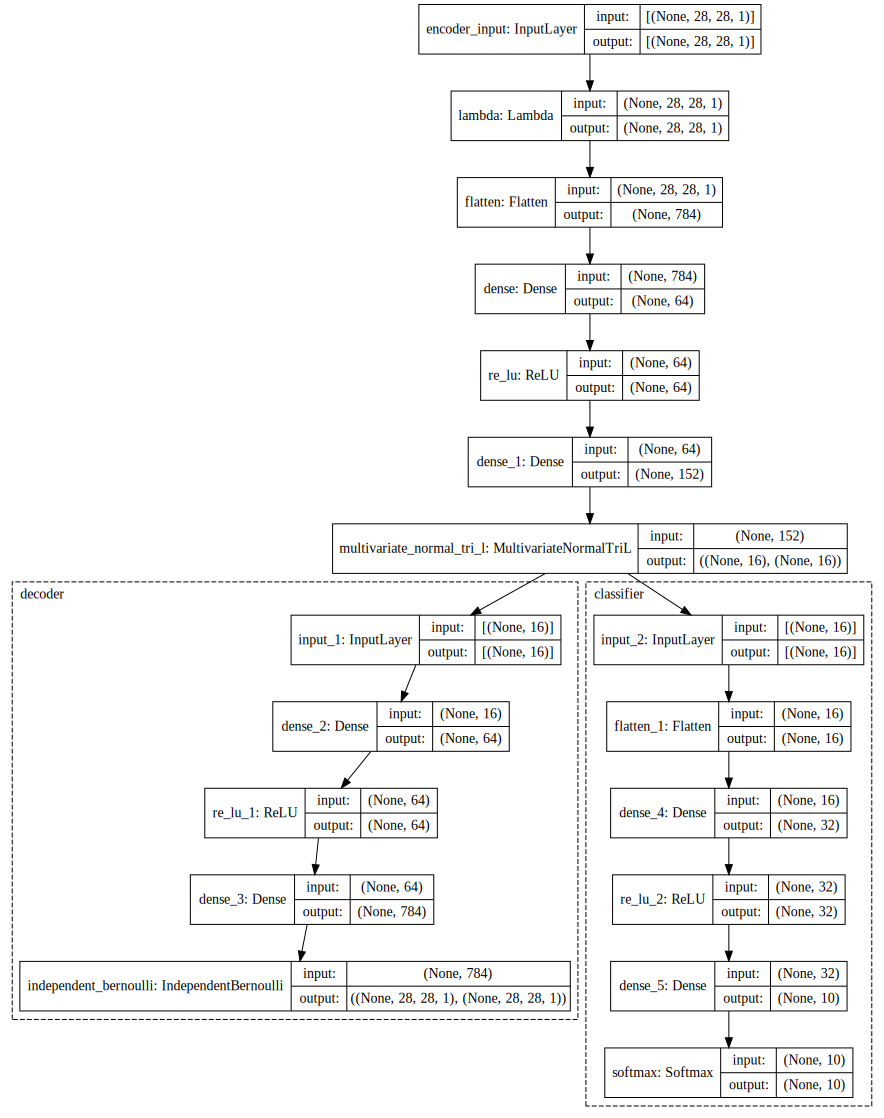

In [25]:
prior = tfp.distributions.Normal(loc=tf.zeros(encoded_size), scale=1) # loc = mean, scale = std
prior = tfp.distributions.Independent(prior, reinterpreted_batch_ndims=1)

encoder = tf.keras.models.Sequential(
    name="encoder",
    layers=[
        tf.keras.layers.InputLayer(input_shape=input_shape, name="encoder_input"),
        tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=hidden_size),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(
            units=tfp.layers.MultivariateNormalTriL.params_size(encoded_size),
            activation=None),
        tfp.layers.MultivariateNormalTriL(
            encoded_size,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior)),
    ])

decoder = tf.keras.models.Sequential(
    name="decoder",
    layers=[
        tf.keras.layers.InputLayer(input_shape=[encoded_size]),
        tf.keras.layers.Dense(units=hidden_size),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(units=output_size),
        tfp.layers.IndependentBernoulli(input_shape, tfp.distributions.Bernoulli.logits),
    ])

classifier = tf.keras.models.Sequential(
    name="classifier",
    layers=[
        tf.keras.layers.InputLayer(input_shape=[encoded_size]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=hidden_size//2),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(units=num_classes),
        tf.keras.layers.Softmax(),
    ])

outputs = [
    decoder(encoder.outputs[0]),
    classifier(encoder.outputs[0]),
]

vae = tf.keras.models.Model(
    name="VAE",
    inputs=encoder.inputs,
    outputs=outputs)

vae.summary()
decoder.summary()
classifier.summary()

display_model(vae, expand_nested=True)

In [26]:
negative_log_likelihood = lambda x, y: -y.log_prob(x) # y is a Random Variable
cross_entropy = tf.losses.SparseCategoricalCrossentropy()

losses = {
    "decoder": negative_log_likelihood,
    "classifier": cross_entropy
}

loss_weights = {
    "decoder": 1.0,
    "classifier": 1000.0
}

metrics = {
    "decoder": [tf.metrics.BinaryAccuracy()],
    "classifier": [tf.metrics.SparseCategoricalAccuracy()],
}

vae.compile(
    optimizer=tf.optimizers.Adam(),
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics)

vae.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=10,
    verbose=2)

Epoch 1/10
938/938 - 24s - loss: 1025.2047 - decoder_loss: 188.3228 - classifier_loss: 0.7646 - decoder_binary_accuracy: 0.8624 - classifier_sparse_categorical_accuracy: 0.7498 - val_loss: 0.0000e+00 - val_decoder_loss: 0.0000e+00 - val_classifier_loss: 0.0000e+00 - val_decoder_binary_accuracy: 0.0000e+00 - val_classifier_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
938/938 - 21s - loss: 547.1493 - decoder_loss: 157.9918 - classifier_loss: 0.3271 - decoder_binary_accuracy: 0.8971 - classifier_sparse_categorical_accuracy: 0.8979 - val_loss: 480.0426 - val_decoder_loss: 154.3194 - val_classifier_loss: 0.2682 - val_decoder_binary_accuracy: 0.9000 - val_classifier_sparse_categorical_accuracy: 0.9197
Epoch 3/10
938/938 - 22s - loss: 463.1316 - decoder_loss: 152.0340 - classifier_loss: 0.2549 - decoder_binary_accuracy: 0.9020 - classifier_sparse_categorical_accuracy: 0.9222 - val_loss: 441.0081 - val_decoder_loss: 148.9591 - val_classifier_loss: 0.2394 - val_decoder_binary_accuracy: 0.

Originals:


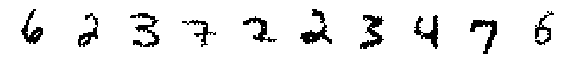

Decoded Random Samples:


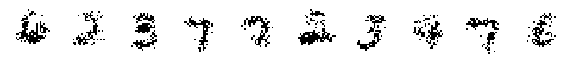

Decoded Modes:


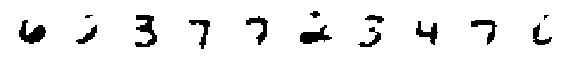

Decoded Means:


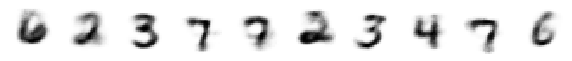

In [27]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0]["encoder_input"][:10]
xhat = vae(x)[0]
assert isinstance(xhat, tfp.distributions.Distribution)

print("Originals:")
display_images(x)

print("Decoded Random Samples:")
display_images(xhat.sample())

print("Decoded Modes:")
display_images(xhat.mode())

print("Decoded Means:")
display_images(xhat.mean())

Randomly Generated Samples:


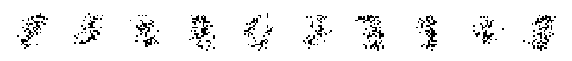

Randomly Generated Modes:


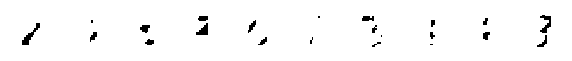

Randomly Generated Means:


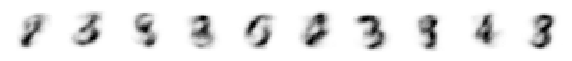

In [28]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfp.distributions.Distribution)

print("Randomly Generated Samples:")
display_images(xtilde.sample())

print("Randomly Generated Modes:")
display_images(xtilde.mode())

print("Randomly Generated Means:")
display_images(xtilde.mean())